In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

load data

In [2]:
X_data = np.load("X_data_fits.npy")
y_data = np.load("y_data_fits.npy")

assign classes (5 spins x 5 incls)

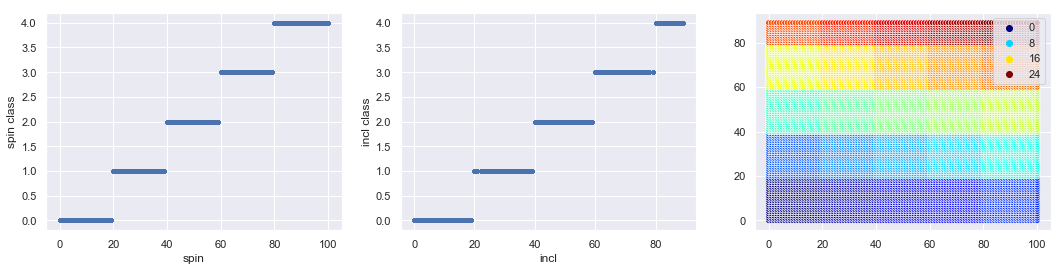

In [3]:
f, ax = plt.subplots(1, 3, figsize=(18,4))

y2d = y_data.copy()
y2d[:,0] = y_data[:,0]//20
idx = np.where(y2d[:,0]==5)[0]
y2d[idx,0] = 4
y2d[:,1] = y_data[:,1]//20
y = y2d[:,1]*5 + y2d[:,0]

ax[0].plot(y_data[:,0],y2d[:,0],'.')
ax[0].set_xlabel('spin')
ax[0].set_ylabel('spin class')
ax[1].plot(y_data[:,1],y2d[:,1],'.')
ax[1].set_xlabel('incl')
ax[1].set_ylabel('incl class')
sns.scatterplot(y_data[:,0], y_data[:,1], hue=y, palette="jet",ax=ax[2])

the map value range before normalizaiotn

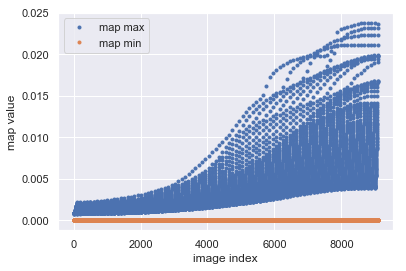

In [4]:
plt.plot(np.max(X_data.reshape(X_data.shape[0],-1), axis = 1), '.', label='map max')
plt.plot(np.min(X_data.reshape(X_data.shape[0],-1), axis = 1), '.', label='map min')
plt.xlabel('image index')
plt.ylabel('map value')
plt.legend()

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# normalize the map to [0,1]
maxmap_arr = np.max(X_data.reshape(X_data.shape[0],-1), axis = 1)
Xnorm = np.tile(maxmap_arr, (X_data.shape[1], X_data.shape[2], 1))
Xnorm = np.swapaxes(Xnorm, 0, 2)
X = X_data/Xnorm

X = X[..., np.newaxis]
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# one hot
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()
batch_size = 32
epochs = 10
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [8]:
ypred = model.predict_classes(X)

Text(0.5, 1.0, 'misclassified points')

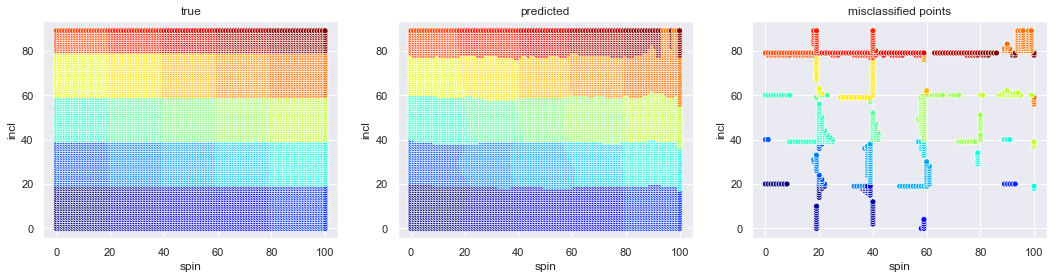

In [9]:
f, ax = plt.subplots(1, 3, figsize=(18,4))

sns.scatterplot(y_data[:,0], y_data[:,1], hue = y, palette="jet", ax=ax[0], legend=None)
ax[0].set_xlabel('spin')
ax[0].set_ylabel('incl')
ax[0].set_title('true')

sns.scatterplot(y_data[:,0], y_data[:,1], hue = ypred, palette="jet", ax=ax[1], legend=None)
ax[1].set_xlabel('spin')
ax[1].set_ylabel('incl')
ax[1].set_title('predicted')

sns.scatterplot(y_data[y!=ypred,0], y_data[y!=ypred,1], 
                hue = ypred[y!=ypred], palette="jet", ax=ax[2], legend=None)
ax[2].set_xlabel('spin')
ax[2].set_ylabel('incl')
ax[2].set_title('misclassified points')

In [10]:
# Save the model
model_yaml = model.to_yaml()
with open("grid_cnn_conti_incl_spin.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("grid_cnn_conti_incl_spin_weights.h5")
yaml_file.close()